# Project Introduction
This notebook performs semantic segmentation on aerial drone images using a deep learning approach. The goal is to classify each pixel in the image into one of several predefined categories, enabling precise analysis of the environment captured by drones

In [1]:
import os
folder_path = '/kaggle/input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks'
images_path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images'

rgb_path = os.listdir(folder_path)
rgb_path.sort()
image_path = os.listdir(images_path)
image_path.sort()


# Required Libraries
The following libraries are used for data processing, visualization, and model training:<br>

OpenCV: For image processing.<br>
NumPy and Pandas: For handling data structures.<br>
Matplotlib: For visualizations.<br>
TensorFlow/PyTorch: For building and training deep learning models.<br>

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Data Overview
RGB images of aerial views captured by drones.<br>
Corresponding segmentation masks with pixel-wise labels.<br>
A class dictionary (class_dict_seg.csv) that maps class IDs to their respective categories.<br>
We aim to preprocess and utilize this dataset effectively for training and evaluation.

In [3]:
= pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
df = pd.DataFrame(df)
print(df)

           name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0


In [4]:
dataset= []

for i in range(len(image_path)):
    image= cv2.imread(os.path.join(images_path,image_path[i]),cv2.IMREAD_COLOR)
    # Resizing every image to 60 x 60
    image = cv2.resize(image,(120,120))
    # Normalize the pixels
    img = image/255.0
    #Convert to  numpy and store them in images
    dataset.append(np.array(img))

In [5]:
# Strip column names to remove any unwanted spaces
df.columns = df.columns.str.strip()

num_classes = 24

# Initialize the labels list
labels = []

# Iterate through your images and labels
for i in range(len(rgb_path)):
    image = cv2.imread(os.path.join(folder_path, rgb_path[i]), cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error: Could not load {rgb_path[i]}")
        continue
    
    # Resize the image
    image = cv2.resize(image, (120, 120))
    x = np.zeros((120, 120, num_classes), dtype=int)  # Initialize one-hot label array
    
    for row_idx, rows in enumerate(np.array(image)):
        for col_idx, pixels in enumerate(rows):
            b, g, r = pixels  # Unpack RGB values
            matched = False
            for j in range(len(df)):
                # Match pixel values with DataFrame
                if r == df.loc[j, 'r'] and g == df.loc[j, 'g'] and b == df.loc[j, 'b']:
                    x[row_idx, col_idx, j] = 1  # Set the class index for this pixel
                    matched = True
                    break
            if not matched:
                x[row_idx, col_idx, 0] = 1  # Default class if no match (class 0)
    
    labels.append(x)  # Append the one-hot encoded label map

# Convert the list of labels to a numpy array
labels = np.array(labels)

# Print summary
print(f"Processed {len(labels)} label maps.")


Processed 400 label maps.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten, Dropout, 
    BatchNormalization, Activation, Input,UpSampling2D
)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import (
    Accuracy, Precision, Recall, MeanSquaredError, MeanAbsoluteError
)

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model

def build_unet(input_shape=(120, 120, 3), num_classes=len(df)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1_1)
    pool1 = MaxPooling2D((2, 2))(conv1_2)
    
    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2_1)
    pool2 = MaxPooling2D((2, 2))(conv2_2)
    
    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3_1)
    pool3 = MaxPooling2D((2, 2))(conv3_2)
    
    # Bottleneck
    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4_1)
    
    # Decoder
    up3 = UpSampling2D((2, 2))(conv4_2)
    up3 = Conv2D(256, (2, 2), activation='relu', padding='same')(up3)
    concat3 = Concatenate()([conv3_2, up3])
    conv5_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
    conv5_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5_1)
    
    up2 = UpSampling2D((2, 2))(conv5_2)
    up2 = Conv2D(128, (2, 2), activation='relu', padding='same')(up2)
    concat2 = Concatenate()([conv2_2, up2])
    conv6_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    conv6_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6_1)
    
    up1 = UpSampling2D((2, 2))(conv6_2)
    up1 = Conv2D(64, (2, 2), activation='relu', padding='same')(up1)
    concat1 = Concatenate()([conv1_2, up1])
    conv7_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv7_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7_1)
    
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')(conv7_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 120, 120, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 120, 120, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 120, 120, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 60, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 60, 60, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 60, 60, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 30, 30, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 30, 30, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 15, 15, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 15, 15, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 15, 15, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 30, 30, 512)    │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 30, 30, 256)    │        524,544 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 30, 30, 512)    │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 30, 30, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 30, 30, 256)    │        590,080 │ conv2d_9[0][0]         │
├──────────────────────

 Total params: 7,608,664 (29.02 MB)

 Trainable params: 7,608,664 (29.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
dataset = np.array(dataset)
labels = np.array(labels)
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(dataset,labels,test_size=0.3)

In [10]:
history = model.fit(
    X_train,  # Training dataset (input images)
    y_train,  # Corresponding labels (either one-hot or integer-encoded)
    # validation_data=(val_data, val_labels),  # Validation dataset
    batch_size=16,  # Adjust based on your dataset and GPU memory
    epochs=100,  # Number of training epochs
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 891ms/step - accuracy: 0.1748 - loss: 3.1393
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.3771 - loss: 2.4621
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.3852 - loss: 2.2406
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.3577 - loss: 2.1752
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.3758 - loss: 2.0866
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.4169 - loss: 2.0405
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.4555 - loss: 1.9327
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.4840 - loss: 1.8699
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.4966 - loss: 1.7982
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.4936 - loss: 1.7556
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.5241 - loss: 1.6823
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `df` contains columns 'r', 'g', 'b' and indices represent the class
color_map = df[['r', 'g', 'b']].values  # Shape: (num_classes, 3)

# Convert predicted class indices to RGB colors
def convert_to_rgb(predicted_mask, color_map):
    # Create an empty RGB image
    height, width = predicted_mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_index, color in enumerate(color_map):
        rgb_image[predicted_mask == class_index] = color  # Map class index to its color

    return rgb_image

# Example usage
predicted_mask = np.argmax(prediction[0], axis=-1)  # Shape: (60, 60)
rgb_image = convert_to_rgb(predicted_mask, color_map)

# Visualize the RGB image using plt
plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.axis('off')  # Hide axes for better visualization
plt.title("Segmented Output")
plt.show()


In [12]:
# Assuming model is compiled and trained
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.7697 - loss: 0.9610 
Test Loss: 1.0271105766296387
Test Accuracy: 0.7553611397743225


In [13]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Predicted classes
y_true_classes = np.argmax(y_test, axis=-1)  # True classes

# Flatten for comparison
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


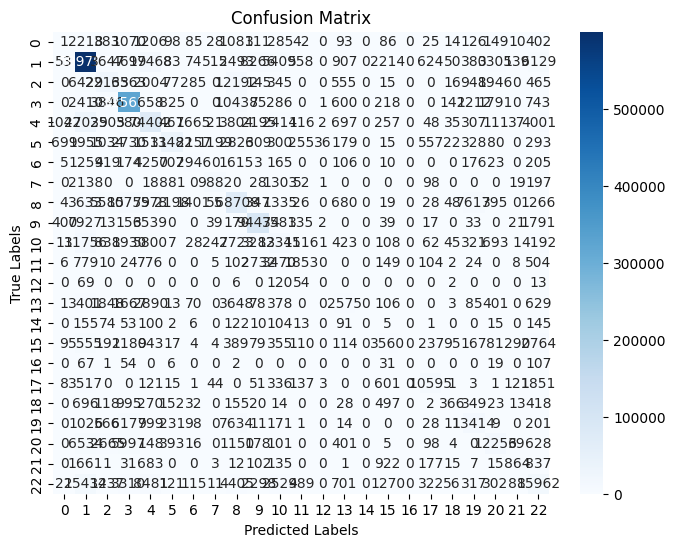

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(len(np.unique(y_true_flat))),
            yticklabels=range(len(np.unique(y_true_flat))))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_true_flat, y_pred_flat)
print("Classification Report:")
print(class_report)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7713
           1       0.85      0.91      0.88    656806
           2       0.47      0.41      0.44     54118
           3       0.87      0.93      0.90    348898
           4       0.56      0.61      0.58    121545
           5       0.84      0.67      0.74     50264
           6       0.33      0.24      0.28     12063
           7       0.82      0.68      0.74     14617
           8       0.56      0.62      0.58    111682
           9       0.82      0.84      0.83    112537
          10       0.35      0.27      0.30     45932
          11       0.36      0.18      0.24     10548
          12       0.00      0.00      0.00       264
          13       0.32      0.14      0.20     17793
          14       0.00      0.00      0.00       896
          15       0.35      0.22      0.27     16145
          16       0.00      0.00      0.00       287
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
